# RNN Track Filter for tree search

In this notebook we will take the trained RNN hit predictor and apply it to track search on ACTS events.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['OMP_NUM_THREADS'] = '4'
cuda = False

In [2]:
from __future__ import print_function

# Data libraries
import numpy as np
import pandas as pd

# Deep learning
import torch

# Visualization
import matplotlib.pyplot as plt

# Local imports
from data import process_files
from track_filter import select_hits, select_signal_hits, coord_scale
from track_filter import remove_duplicate_hits_2 as remove_duplicate_hits
import torchutils
torchutils.set_cuda(cuda)

%matplotlib notebook

In [3]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

def calc_dphi(phi1, phi2):
    """TODO: update this for signed dph"""
    dphi = np.abs(phi1 - phi2)
    idx = dphi > np.pi
    dphi[idx] = 2*np.pi - dphi[idx]
    return dphi

def calc_dR(eta1, eta2, phi1, phi2):
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(deta*deta + dphi*dphi)

def calc_phi_z_distance(phi1, phi2, z1, z2):
    dphi = calc_dphi(phi1, phi2)
    dz = np.abs(z1 - z2)
    return np.sqrt(dphi*dphi + dz*dz)

def calc_eta_phi_distance(r1, phi1, z1, r2, phi2, z2):
    # First, calculate the eta coordinates
    eta1 = calc_eta(r1, z1)
    eta2 = calc_eta(r2, z2)
    deta = np.abs(eta1 - eta2)
    dphi = calc_dphi(phi1, phi2)
    return np.sqrt(dphi*dphi + deta*deta)    

In [4]:
ls /global/cscratch1/sd/sfarrell/heptrkx/RNNFilter_006

README  losses.npz  model  out.log


In [5]:
data_dir = '/global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29'
model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter_006/model'
#model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter_20180203_2242/model'
#model_file = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter-2/model'

## Load a held-out test set

I set aside the last 10 files from the directory (sorted alphabetically by os.listdir) as an additional held-out test set for track building evaluation. So here we take from the back of the file list.

In [6]:
n_files = 1

all_files = os.listdir(data_dir)
hits_files = sorted(f for f in all_files if f.startswith('clusters'))
hits_files = [os.path.join(data_dir, f) for f in hits_files[-n_files:]]

In [7]:
%%time

n_workers = 1
hits = process_files(hits_files, num_workers=n_workers)

Loading /global/cscratch1/sd/sfarrell/ACTS/prod_mu10_pt1000_2017_07_29/clusters_99.csv
CPU times: user 30.8 ms, sys: 47.7 ms, total: 78.5 ms
Wall time: 1min 6s


In [8]:
print('Hits data shape:', hits.shape)

Hits data shape: (529333, 7)


In [9]:
%%time

# Select hits
selected_hits = remove_duplicate_hits(select_hits(hits))
print('selected barrel hits:', selected_hits.shape)
signal_hits = select_signal_hits(selected_hits)
print('signal track hits:', signal_hits.shape)

selected barrel hits: (270060, 7)
signal track hits: (136910, 7)
CPU times: user 55 s, sys: 201 ms, total: 55.2 s
Wall time: 55.2 s


In [10]:
event_groups = selected_hits.groupby('evtid')
sample_keys = signal_hits[['evtid', 'barcode']].drop_duplicates().values

In [11]:
print('Available sample keys:', sample_keys.shape[0])

Available sample keys: 13691


In [12]:
# Load the pre-trained model
model = torch.load(model_file)
model.eval()
model

HitPredictor(
  (lstm): LSTM(3, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=2)
)

In [13]:
def center_hits_phi(hits, phi0):
    dphi = hits.phi - phi0
    dphi[dphi > np.pi] -= 2*np.pi
    dphi[dphi < -np.pi] += 2*np.pi
    hits.phi = dphi
    
def make_inputs(x, phi0=0):
    """
    Takes a dataframe of hits and extracts out the model input features.    
    Scales the coordinates by standard factors and prepends a batch dimension.
    """
    return torchutils.np_to_torch(
        (x[['phi', 'z', 'r']].values / coord_scale)
        .astype(np.float32))[None, :]

In [14]:
n_det_layers = 10
seed_size = 3

n_test = 10240

In [15]:
%%time

# Selected hit entries for every sample
sel_indices = []
# True labels of all selected hit entries
sel_labels = []

# Loop over samples
for k in sample_keys[:n_test]:

    # Gather the data
    sample_hits = event_groups.get_group(k[0]).sort_values('layer')
    sample_labels = sample_hits.barcode == k[1]
    
    # Prepare the seed
    seed_hits = sample_hits[(sample_hits.layer < seed_size) &
                            (sample_hits.barcode == k[1])]
    sel_idx = seed_hits.index
    
    # Center hits in phi on the first layer seed hit
    phi0 = sample_hits.phi.loc[sel_idx[0]]
    center_hits_phi(sample_hits, phi0)
    
    for layer in range(seed_size, n_det_layers):

        # Calculate the prediction for next layer
        model_input = make_inputs(sample_hits.loc[sel_idx])
        model_pred = model(model_input)[0, -1]
        pred = torchutils.torch_to_np(model_pred) * coord_scale[:2]

        # Select all hits on the next layer
        layer_hits = sample_hits[sample_hits.layer == layer]

        # Calculate distance from prediction.
        distances = calc_eta_phi_distance(layer_hits.r, layer_hits.phi, layer_hits.z,
                                          layer_hits.r, pred[0], pred[1])

        # Select the closest
        next_idx = distances.argmin()
        sel_idx = sel_idx.append(pd.Int64Index([next_idx]))

    sel_indices.append(sel_idx)
    sel_labels.append(sample_labels.loc[sel_idx])

# Stack the results into full dataset tensors
sel_labels = np.stack(sel_labels)
sel_indices = np.stack(sel_indices)

CPU times: user 9min 55s, sys: 5.52 s, total: 10min
Wall time: 10min 1s


In [16]:
print('Fraction of correctly selected hits:', sel_labels[:, seed_size:].mean())

Fraction of correctly selected hits: 0.999344308036


### Visualize some samples

<IPython.core.display.Javascript object>


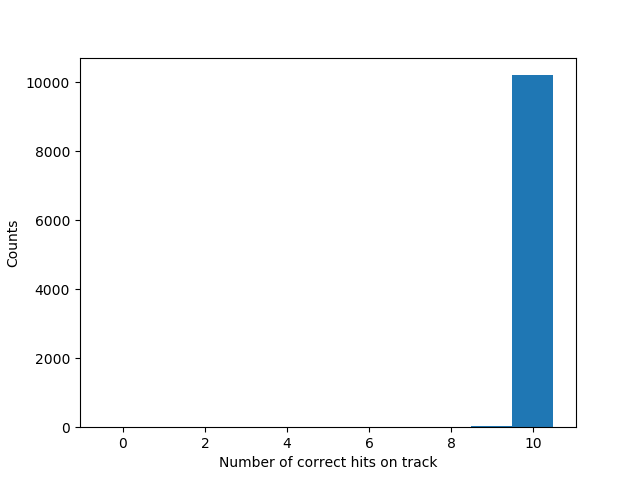

In [17]:
# Draw histogram of the number of correct hits in the predictions
correct_counts = sel_labels.sum(axis=1)

plt.figure()
plt.hist(correct_counts, range=(-0.5, 10.5), bins=11)
plt.xlabel('Number of correct hits on track')
plt.ylabel('Counts');

In [18]:
draw_samples = np.random.randint(n_test, size=5)
#draw_samples = [25, 48, 42, 64, 331, 228]

<IPython.core.display.Javascript object>


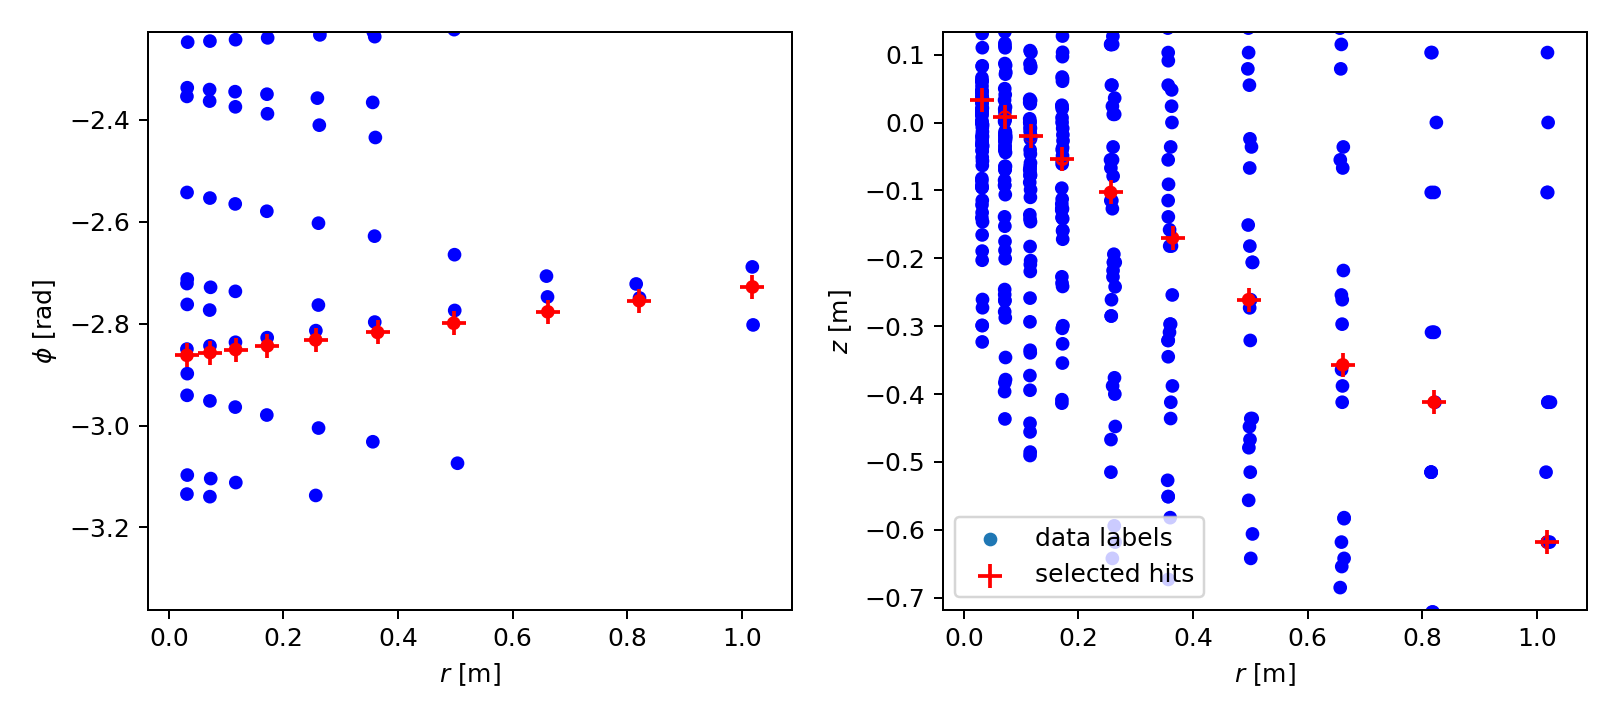

<IPython.core.display.Javascript object>


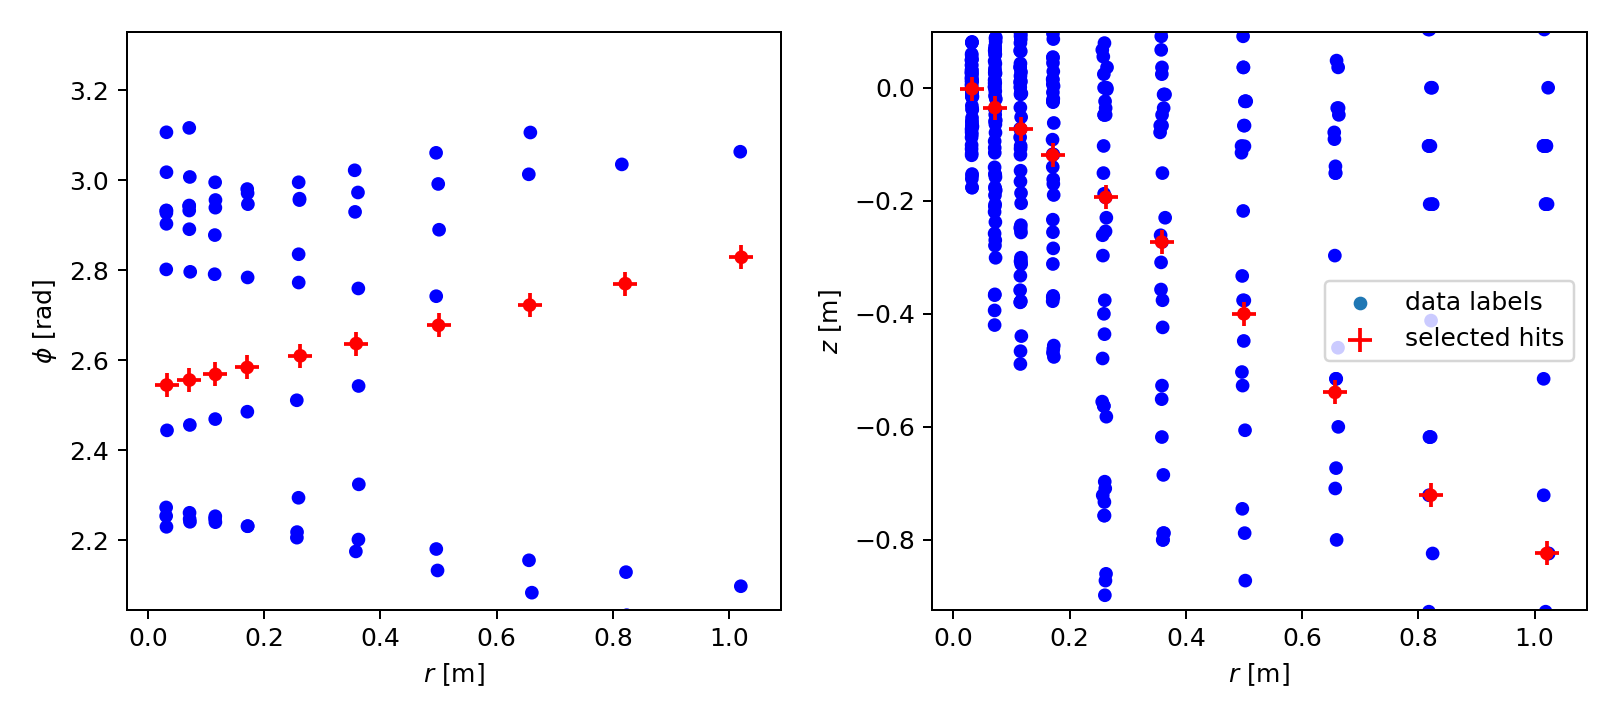

<IPython.core.display.Javascript object>


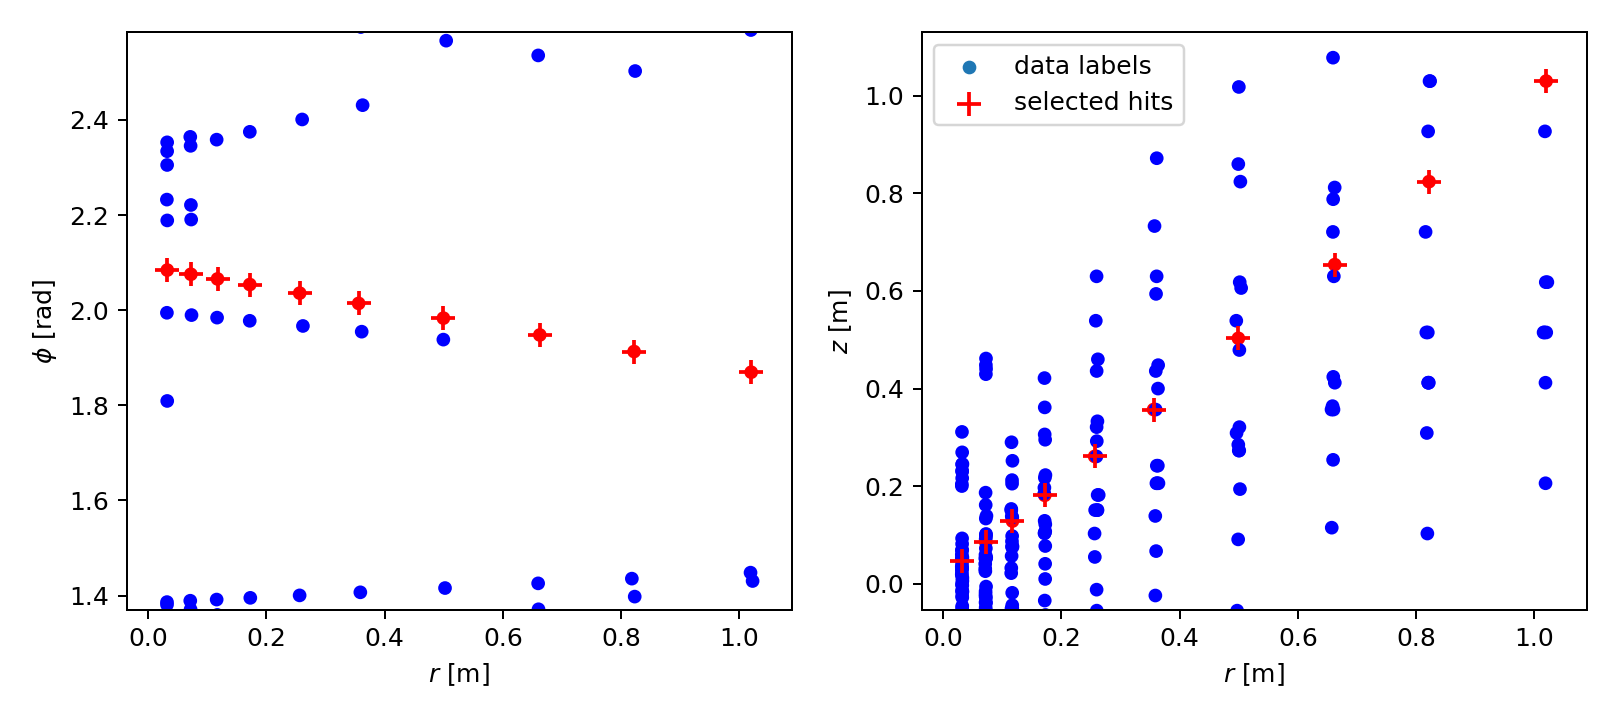

<IPython.core.display.Javascript object>


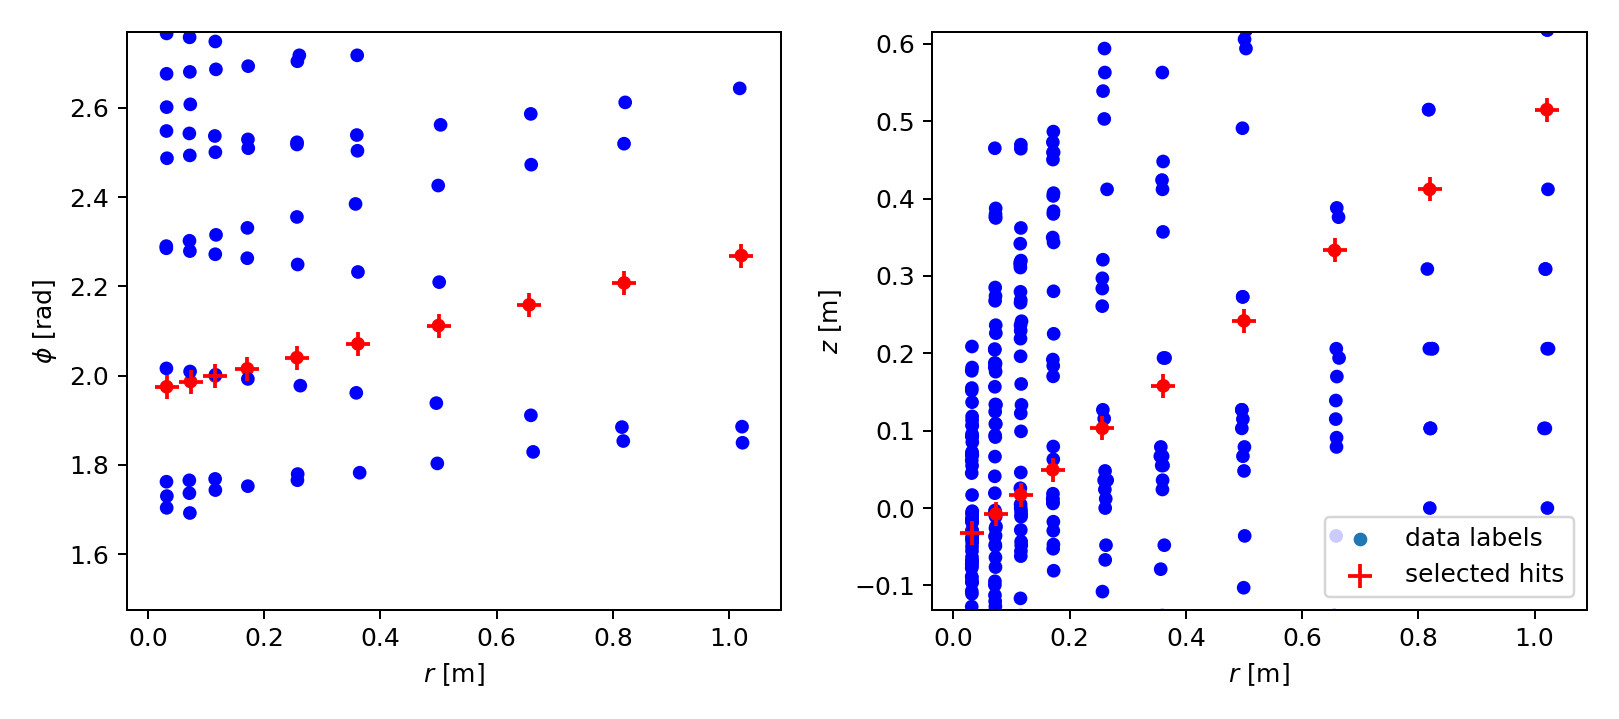

<IPython.core.display.Javascript object>


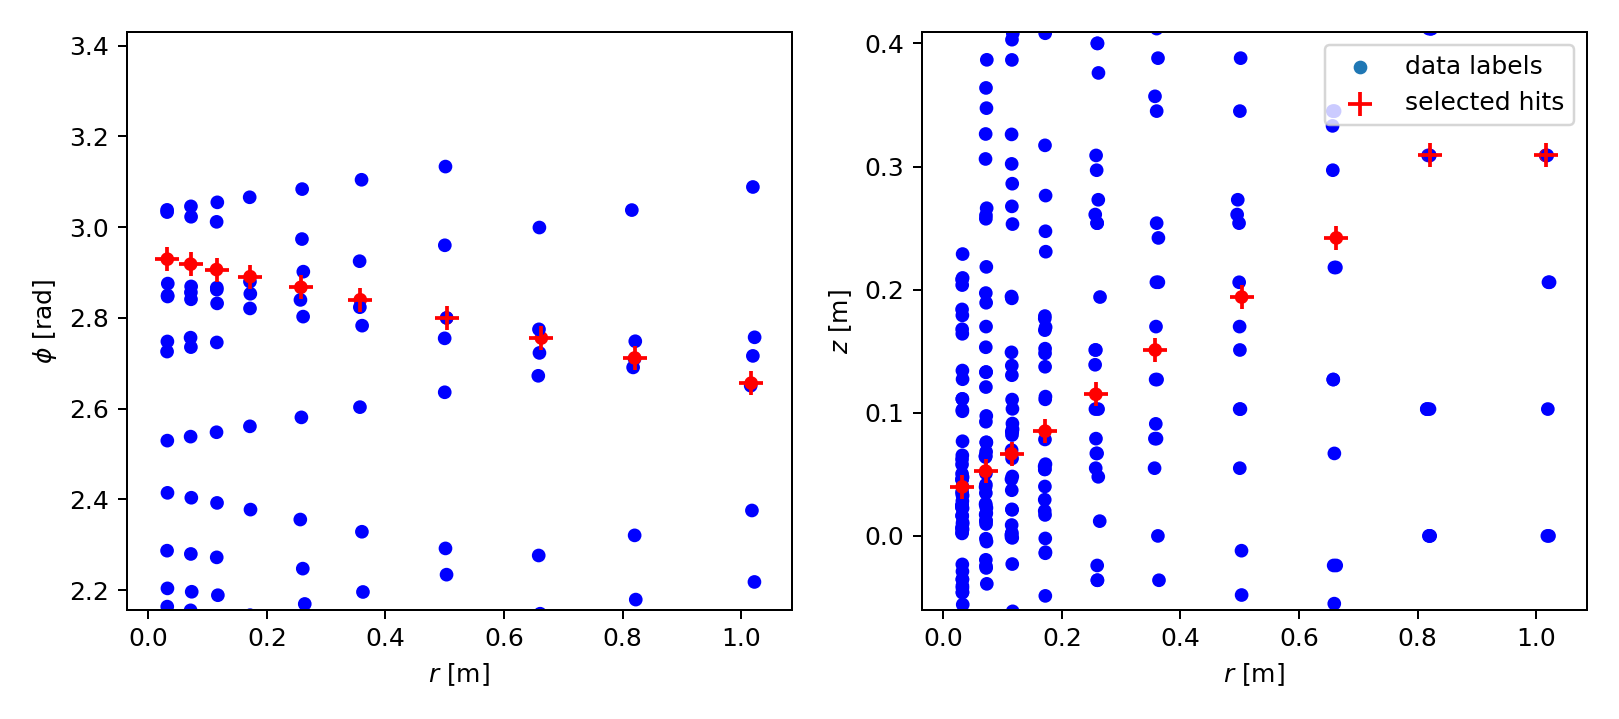

In [25]:
# Loop over samples to draw
for isample in draw_samples:
    sample_key = sample_keys[isample]

    # Get the hits for this sample
    sample_hits = event_groups.get_group(sample_key[0])
    sample_labels = sample_hits.barcode == sample_key[1]

    # Get the hits selected by our model
    sample_sel_idx = pd.Int64Index(sel_indices[isample])
    sample_sel_hits = sample_hits.loc[sample_sel_idx]

    plt.figure(figsize=(9, 4))
    plt.subplot(121)
    plt.scatter(sample_hits.r*0.001, sample_hits.phi, c=sample_labels, s=20, cmap='bwr', label='data labels')
    plt.scatter(sample_sel_hits.r*0.001, sample_sel_hits.phi, marker='+', c='r', s=100, label='selected hits')
    plt.ylim((sample_sel_hits.phi.min() - 0.5, sample_sel_hits.phi.max() + 0.5))
    plt.xlabel('$r$ [m]')
    plt.ylabel('$\phi$ [rad]')

    plt.subplot(122)
    plt.scatter(sample_hits.r*0.001, sample_hits.z*0.001, c=sample_labels, s=20, cmap='bwr', label='data labels')
    plt.scatter(sample_sel_hits.r*0.001, sample_sel_hits.z*0.001, marker='+', c='r', s=100, label='selected hits')
    plt.ylim((sample_sel_hits.z.min()*0.001 - 0.1, sample_sel_hits.z.max()*0.001 + 0.1))
    plt.xlabel('$r$ [m]')
    plt.ylabel('$z$ [m]')
    plt.legend(loc=0)

    plt.tight_layout()

## Discussion

Wow, this already works quite well. In this simple, low occupancy data, the closest hit to the prediction is the correct one the vast majority of the time. The track builder selects the correct hit 99.9% of the time!